In [1]:
import pandas as pd

df_msft = pd.read_csv('MSFT.csv')
df_amzn = pd.read_csv('AMZN.csv')
df_goog = pd.read_csv('GOOG.csv')
df_meta = pd.read_csv('META.csv')
df_tsla = pd.read_csv('TSLA.csv')

df_tsla

FileNotFoundError: ignored

In [ ]:

df_msft = df_msft[['Date', 'Close']]
df_amzn = df_amzn[['Date', 'Close']]
df_goog = df_goog[['Date', 'Close']]
df_meta = df_meta[['Date', 'Close']]
df_tsla =df_tsla[['Date', 'Close']]

df_msft['Date']

0     2023-06-12
1     2023-06-13
2     2023-06-14
3     2023-06-15
4     2023-06-16
         ...    
57    2023-09-01
58    2023-09-05
59    2023-09-06
60    2023-09-07
61    2023-09-08
Name: Date, Length: 62, dtype: object

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [ ]:
df_msft['Date']= df_msft['Date'].apply(str_to_datetime)
df_amzn['Date']= df_amzn['Date'].apply(str_to_datetime)
df_goog['Date']= df_goog['Date'].apply(str_to_datetime)
df_meta['Date']= df_meta['Date'].apply(str_to_datetime)
df_tsla['Date']= df_tsla['Date'].apply(str_to_datetime)


<ipython-input-33-64d2c611216b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tsla['Date']= df_tsla['Date'].apply(str_to_datetime)


In [ ]:
df_msft.index  = df_msft.pop('Date')
df_amzn.index  = df_amzn.pop('Date')
df_goog.index  = df_goog.pop('Date')
df_meta.index  = df_meta.pop('Date')
df_tsla.index  = df_tsla.pop('Date')


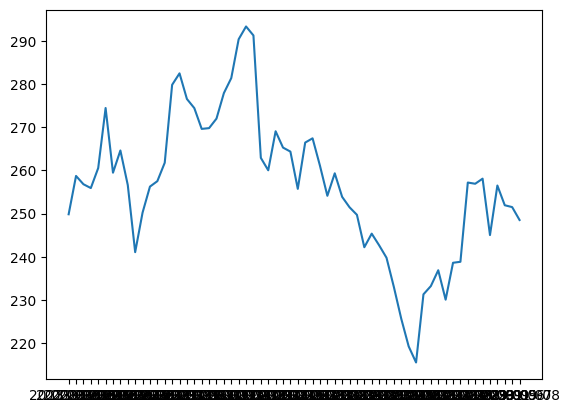

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df_tsla.index, df_tsla['Close'])

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df_tsla   = df_to_windowed_df(df_tsla,
                                 '2023-06-15',
                                '2023-09-08',
                                n=3)
windowed_df_meta = df_to_windowed_df(df_meta,
                                '2023-06-15',
                                '2023-09-08',
                                n=3)
windowed_df_goog= df_to_windowed_df(df_goog,
                                '2023-06-15',
                                '2023-09-08',
                                n=3)
windowed_df_amzn = df_to_windowed_df(df_amzn,
                                '2023-06-15',
                                '2023-09-08',
                                n=3)
windowed_df_msft = df_to_windowed_df(df_msft,
                                '2023-06-15',
                                '2023-09-08',
                                n=3)

windowed_all= pd.concat([windowed_df_tsla, windowed_df_meta,windowed_df_goog,windowed_df_amzn,windowed_df_msft], ignore_index=True)
windowed_all = windowed_all.sample(frac = 1)
windowed_all


,Target Date,Target-3,Target-2,Target-1,Target
117,2023-09-08,300.149994,299.170013,298.670013,297.890015
253,2023-07-12,337.220001,331.829987,332.470001,337.200012
75,2023-07-11,291.989990,290.529999,294.100006,298.290009
135,2023-07-12,120.139999,116.870003,117.709999,119.620003
294,2023-09-08,333.549988,332.880005,329.910004,334.269989
...,...,...,...,...,...
229,2023-08-30,133.259995,133.139999,134.910004,135.070007
94,2023-08-07,314.309998,313.190002,310.730011,316.559998
5,2023-06-23,274.450012,259.459991,264.609985,256.600006
81,2023-07-19,308.869995,310.619995,312.049988,316.010010


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates_df_all, Xdf_all, ydf_all = windowed_df_to_date_X_y(windowed_all)


dates_df_all.shape, Xdf_all.shape, ydf_all.shape

((295,), (295, 3, 1), (295,))

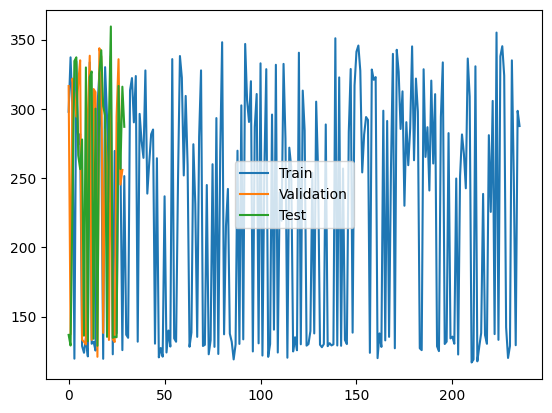

In [ ]:
q_80 = int(len(dates_df_all) * .8)
q_90 = int(len(dates_df_all) * .9)

dates_train, X_train, y_train = dates_df_all[:q_80], Xdf_all[:q_80], ydf_all[:q_80]

dates_val, X_val, y_val = dates_df_all[q_80:q_90], Xdf_all[q_80:q_90], ydf_all[q_80:q_90]
dates_test, X_test, y_test =dates_df_all[q_90:], Xdf_all[q_90:], ydf_all[q_90:]

plt.plot( y_train)
plt.plot( y_val)
plt.plot( y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
8/8 [==============================] - 3s 85ms/step - loss: 58114.4141 - mean_absolute_error: 225.5236 - val_loss: 67867.7188 - val_mean_absolute_error: 246.0111
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 57932.8984 - mean_absolute_error: 225.1302 - val_loss: 67731.6016 - val_mean_absolute_error: 245.7403
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 57793.3555 - mean_absolute_error: 224.8288 - val_loss: 67530.2969 - val_mean_absolute_error: 245.3379
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 57595.2656 - mean_absolute_error: 224.3978 - val_loss: 67304.5547 - val_mean_absolute_error: 244.8731
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 57364.9961 - mean_absolute_error: 223.8762 - val_loss: 67005.0078 - val_mean_absolute_error: 244.2436
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 57012.6328 - mean_absolute_error: 223.0764 - val_loss: 66474.46

8/8 [==============================] - 0s 2ms/step


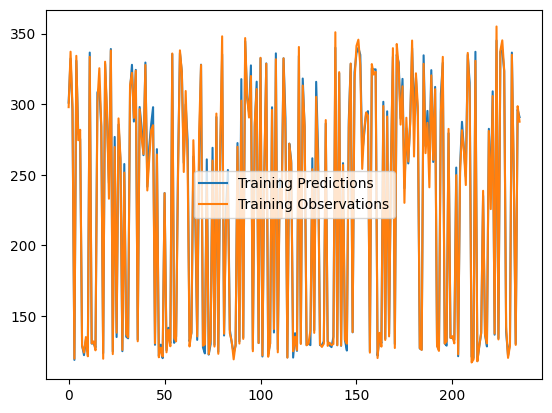

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(train_predictions)
plt.plot(y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 23ms/step


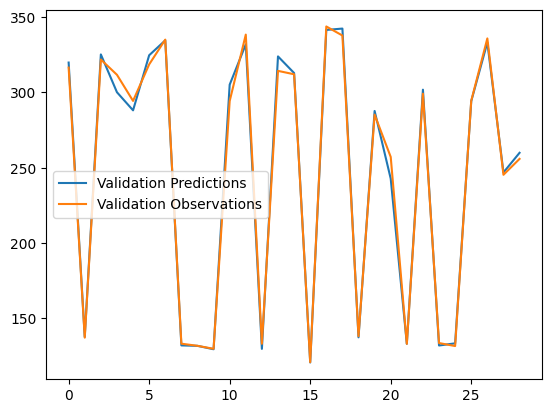

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(val_predictions)
plt.plot(y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

(30, 3, 1)
1/1 [==============================] - 0s 21ms/step


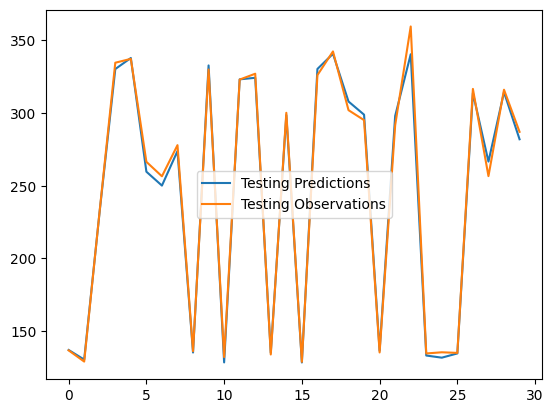

In [ ]:
print(X_test.shape)
test_predictions = model.predict(X_test).flatten()


plt.plot(test_predictions)
plt.plot(y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
MSFT = np.array([330.61, 338.41, 335.72])
MSFT=np.reshape(MSFT,(1,3,1))
MSFT.shape
test_predictions_MSFT = model.predict(MSFT)
print(test_predictions_MSFT)

1/1 [==============================] - 0s 19ms/step
[[334.88812]]
